# Séance 7 : PIG et Paramètres (Cloudera)

In [2]:
import pyensae
%nb_menu

## Paramètres

Les sites web produisent des données en continu. On utilise fréquemment le même script pour traiter les donnéesd'un jour, du lendemain, de jour d'après... Tous les jours, on veut récupérer la fréquentation de la veille. La seule chose qui change est la date des données qu'on veut traiter. Plutôt que de recopier un script en entier pour changer une date qui apparaît parfois à plusieurs endroits, il est préférable d'écrire un script ou la date apparaît comme une variable.

Ce notebook va illustrer ce procédé sur la construction d'un histogramme. Le paramètre du script sera la largeur des barres de l'histogramme (ou [bin](http://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width) en anglais).

## Connexion au cluster

On prend le cluster [Cloudera](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td3a_cenonce_session6.html#p2). Il faut exécuter ce script pour pouvoir notifier au notebook que la variable ``params`` existe.

In [1]:
import pyensae, pyquickhelper
params={"server":"df...fr", "username":"", "password":""}
pyquickhelper.open_html_form(params=params,title="server + credentials", key_save="params")

In [1]:
import pyensae
password = params["password"]
server = params["server"]
username = params["username"]
client = %remote_open
client

## Upload version

On commence par simuler des données.

In [3]:
import random
with open("random.sample.txt", "w") as f :
    for i in range(0,10000) :
        x = random.random()
        f.write(str(x)+"\n")

On créé un répertoire sur le cluster :

In [12]:
%dfs_mkdir random

('', '')

In [15]:
%remote_up_cluster random.sample.txt random/random.sample.txt

'random/random.sample.txt'

## PIG et paramètres

On indique un paramètre par le symbole : ``$bins``. La valeur du paramètre est passé sous forme de chaîne de caractères au script et remplacée telle quelle dans le script. Il en va de même des constantes déclarées grâce au mot-clé [%declare](https://pig.apache.org/docs/r0.11.1/cont.html#Examples-N1060D).

La sortie du script inclut le paramètre : cela permet de retrouver comment ces données ont été générées.

In [14]:
%%PIG histogram.pig

values = LOAD 'random/random.sample.txt' USING PigStorage('\t') AS (x:double);

values_h = FOREACH values GENERATE x, ((int)(x / $bins)) * $bins AS h ;

hist_group = GROUP values_h BY h ;

hist = FOREACH hist_group GENERATE group, COUNT(values_h) AS nb ;

STORE hist INTO 'random/histo_$bins.txt' USING PigStorage('\t') ;

Pour supprimer les précédents résultats :

In [15]:
if client.dfs_exists("random/histo_0.1.txt"):
    client.dfs_rm("random/histo_0.1.txt", recursive=True)

On exécute le job. Comme la commande magique supportant les paramètres n'existe pas encore, il faut utiliser la variable ``client`` et sa méthode [pig_submit](http://www.xavierdupre.fr/app/pyensae/helpsphinx/pyensae/remote/ssh_remote_connection.html?highlight=pig_submit#pyensae.remote.ssh_remote_connection.ASSHClient.pig_submit) qui fait la même chose. Elle upload le script puis le soumet.

In [16]:
client.pig_submit("histogram.pig", redirection="redirection", params =dict(bins="0.1") )

('', '')

S'il se produit des erreurs, il est recommandé d'afficher plus de lignes :

In [19]:
%remote_cmd tail redirection.err

On vérifie que tout s'est bien passé. La taille devrait être équivalent à l'entrée.

In [20]:
%dfs_ls random

,attributes,code,alias,folder,size,date,time,name,isdir
0,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-28,00:11,random/histo_0.1.txt,True
1,-rw-r--r--,3,xavierdupre,xavierdupre,202586,2014-11-27,23:38,random/random.sample.txt,False


In [21]:
if os.path.exists("histo.txt") : os.remove("histo.txt")
client.download_cluster("random/histo_0.1.txt","histo.txt", merge=True)

'random/histo_0.1.txt'

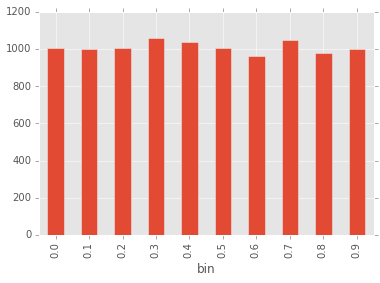

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas
df = pandas.read_csv("histo.txt", sep="\t",names=["bin","nb"])
df.plot(x="bin", y="nb", kind="bar")

## Exercice 1 : min, max

Ajouter deux paramètres pour construire l'histogramme entre deux valeurs ``a``,``b``.